In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("telecom_churn.csv")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [5]:
df["TotalCharges"] = df["TotalCharges"].fillna(0)

In [6]:
df = df.drop(columns=["customerID"])

In [7]:
df = df.drop_duplicates()

In [8]:
df["SeniorCitizen"] = df["SeniorCitizen"].map({0:"No",1:"Yes"})

In [9]:
cols = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

for col in cols:
    df[col] = df[col].replace('No internet service', 'No')

df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')

In [10]:
df["Churn"] = df["Churn"].map({"No":0,"Yes":1})

In [11]:
X = df.drop(columns=["Churn"])
y = df["Churn"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
numeric_features = ['tenure', 'MonthlyCharges']
binary_features = ["gender","SeniorCitizen","Partner","Dependents","PhoneService","PaperlessBilling","MultipleLines","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
categorical_features = ["InternetService","Contract","PaymentMethod"]

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("bin", OneHotEncoder(drop='if_binary',handle_unknown="ignore"), binary_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__min_child_weight': 5, 'model__n_estimators': 300, 'model__reg_lambda': 10, 'model__subsample': 1.0

In [15]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    colsample_bytree=0.8,   
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=5,
    n_estimators=300,
    reg_lambda=10,
    subsample=1.0,
    scale_pos_weight=scale_pos_weight
)
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb)
])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1033
           1       0.52      0.80      0.63       372

    accuracy                           0.75      1405
   macro avg       0.72      0.77      0.72      1405
weighted avg       0.81      0.75      0.77      1405

[[763 270]
 [ 76 296]]
ROC-AUC: 0.8434926979566769


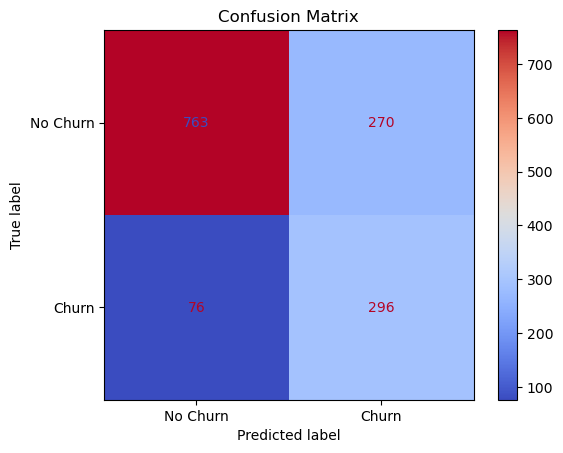

In [16]:
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
display.plot(cmap="coolwarm")
plt.title('Confusion Matrix')
plt.show()

In [17]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['tenure', 'MonthlyCharges']),
                                                 ('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'PaperlessBilling',
                                                   'MultipleLines',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Streamin...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [18]:
from sklearn.utils import resample
from sklearn.base import clone
N_BOOTSTRAP = 100
bootstrap_models = []

for i in range(N_BOOTSTRAP):
    X_bs, y_bs = resample(
        X_train, y_train,
        replace=True,
        random_state=42 + i
    )
    m = clone(pipe)      
    m.fit(X_bs, y_bs)
    bootstrap_models.append(m)

In [19]:
import sys
import numpy as np
import pandas as pd
import sklearn
import xgboost
import joblib

print("Python       :", sys.version)
print("NumPy        :", np.__version__)
print("Pandas       :", pd.__version__)
print("scikit-learn :", sklearn.__version__)
print("XGBoost      :", xgboost.__version__)
print("joblib       :", joblib.__version__)

Python       : 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
NumPy        : 2.3.4
Pandas       : 2.2.3
scikit-learn : 1.6.1
XGBoost      : 3.1.2
joblib       : 1.4.2
